In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!ls "/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/"

 clr_callback.py		 'Pet Adoption (CB) - PC.ipynb'
 Dataset			 'Pet Adoption (EDA).ipynb'
 learningratefinder.py		 'Pet Adoption (LGB) - BC.ipynb'
'NPZ Files'			 'Pet Adoption (LGB) - PC.ipynb'
'Pet Adoption (ANN) - BC.ipynb'   Predictions
'Pet Adoption (ANN) - PC.ipynb'   __pycache__
'Pet Adoption (CB) - BC.ipynb'


In [3]:
import sys
sys.path.insert(1, '/content/drive/My Drive/Colab Notebooks/Adopt a Buddy')

In [4]:
%tensorflow_version 2.x

In [5]:
! pip install optuna

     |████████████████████████████████| 235kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 8.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 81kB 7.0MB/s 
     |████████████████████████████████| 133kB 15.2MB/s 
     |████████████████████████████████| 112kB 17.6MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=e27e30ff6db7fa3611dbf718c28bb7ede70275120c6db6e5a41efe9411279aa8
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-2.0.0-cp36-none-any.whl size=312964 sha256=92ef16266b76a15859b7b33d4c59b698aac19378028cc1a0fafe7b9db5daa697
  Stored in directory: /root/.cache/pip/wheels/b5/

## Import Packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.decomposition import PCA
import featuretools as ft
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam, RMSprop
from learningratefinder import LearningRateFinder
from clr_callback import CyclicLR
import optuna

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Set file paths for train and predict datasets

In [ ]:
train_dataset = "/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/Dataset/train.csv"
predict_dataset = "/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/Dataset/test.csv"

## Data Preprocessing

### Read train and predict datasets

In [ ]:
train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(predict_dataset)
print("train_df: {}".format(train_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (18834, 11)
predict_df: (8072, 9)


### Extract target variables into NumPy arrays

In [ ]:
train_y_bc = np.array([train_df['breed_category'].values]).T
train_df.drop(['breed_category','pet_category'], inplace=True, axis=1)
print("train_y_bc: {}".format(train_y_bc.shape))

train_y_bc: (18834, 1)


In [ ]:
temp_df = pd.DataFrame(train_y_bc, columns=['Class'])
temp_df.groupby(['Class']).size().reset_index().rename(columns={0:'count'})

,Class,count
0,0.0,9000
1,1.0,8357
2,2.0,1477


### Combine train and predict dataframes

In [ ]:
combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
combined_df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4


### Feature Engineering

#### Issue Date and Listing Date

In [ ]:
combined_df['iss_dt_year'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).year)
combined_df['iss_dt_quarter'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).quarter)
combined_df['iss_dt_month'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).month)
combined_df['iss_dt_week'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).week)
combined_df['iss_dt_day_year'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).dayofyear)
combined_df['iss_dt_day_month'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).day)
combined_df['iss_dt_day_week'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).dayofweek)
combined_df['iss_dt_day_weekend'] = np.where(combined_df['iss_dt_day_week'].isin([5,6]),1,0)

In [ ]:
combined_df['lst_dt_year'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).year)
combined_df['lst_dt_quarter'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).quarter)
combined_df['lst_dt_month'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).month)
combined_df['lst_dt_week'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).week)
combined_df['lst_dt_day_year'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).dayofyear)
combined_df['lst_dt_day_month'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).day)
combined_df['lst_dt_day_week'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).dayofweek)
combined_df['lst_dt_day_weekend'] = np.where(combined_df['lst_dt_day_week'].isin([5,6]),1,0)
combined_df['lst_dt_hour'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).hour)
combined_df['lst_dt_minute'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).minute)
combined_df['lst_dt_minutes_elapsed'] = combined_df['listing_date'].map(lambda x: (pd.to_datetime(x) - pd.to_datetime(pd.to_datetime(x).date())).seconds / 60.0)

In [ ]:
combined_df['dt_diff'] = (pd.to_datetime(combined_df['listing_date']) - pd.to_datetime(combined_df['issue_date']))
combined_df['dt_diff_days'] = combined_df['dt_diff']/np.timedelta64(1,'D')
combined_df['dt_diff_weeks'] = combined_df['dt_diff']/np.timedelta64(1,'W')
combined_df['dt_diff_mnths'] = combined_df['dt_diff']/np.timedelta64(1,'M')
combined_df['dt_diff_yrs'] = combined_df['dt_diff']/np.timedelta64(1,'Y')
combined_df['dt_diff_sec'] = combined_df['dt_diff']/np.timedelta64(1,'s')
combined_df['dt_diff_min'] = combined_df['dt_diff']/np.timedelta64(1,'m')
combined_df['dt_diff_hrs'] = combined_df['dt_diff']/np.timedelta64(1,'h')

In [ ]:
combined_df['curr_iss_dt_diff'] = (pd.datetime.now() - pd.to_datetime(combined_df['issue_date']))
combined_df['curr_iss_dt_diff_mnths'] = combined_df['curr_iss_dt_diff']/np.timedelta64(1,'M')
combined_df['curr_iss_dt_diff_yrs'] = combined_df['curr_iss_dt_diff']/np.timedelta64(1,'Y')

combined_df['curr_lst_dt_diff'] = (pd.datetime.now() - pd.to_datetime(combined_df['listing_date']))
combined_df['curr_lst_dt_diff_mnths'] = combined_df['curr_lst_dt_diff']/np.timedelta64(1,'M')
combined_df['curr_lst_dt_diff_yrs'] = combined_df['curr_lst_dt_diff']/np.timedelta64(1,'Y')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



In [ ]:
combined_df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_week,iss_dt_day_year,iss_dt_day_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_week,lst_dt_day_year,lst_dt_day_month,lst_dt_day_week,lst_dt_day_weekend,lst_dt_hour,lst_dt_minute,lst_dt_minutes_elapsed,dt_diff,dt_diff_days,dt_diff_weeks,dt_diff_mnths,dt_diff_yrs,dt_diff_sec,dt_diff_min,dt_diff_hrs,curr_iss_dt_diff,curr_iss_dt_diff_mnths,curr_iss_dt_diff_yrs,curr_lst_dt_diff,curr_lst_dt_diff_mnths,curr_lst_dt_diff_yrs
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,2016,3,7,27,192,10,6,1,2016,3,9,38,265,21,2,0,16,25,985.0,73 days 16:25:00,73.684028,10.526290,2.420880,0.201740,6366300.0,106105.0,1768.416667,1504 days 08:04:50.317818,49.424808,4.118734,1430 days 15:39:50.334039,47.003928,3.916994
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,2013,4,11,47,325,21,3,0,2018,4,12,52,361,27,3,0,17,47,1067.0,1862 days 17:47:00,1862.740972,266.105853,61.200139,5.100012,160940820.0,2682347.0,44705.783333,2466 days 08:04:50.317818,81.031206,6.752601,603 days 14:17:50.334039,19.831067,1.652589
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2014,3,9,39,271,28,6,1,2016,4,10,42,293,19,2,0,8,24,504.0,752 days 08:24:00,752.350000,107.478571,24.718372,2.059864,65003040.0,1083384.0,18056.400000,2155 days 08:04:50.317818,70.813337,5.901111,1402 days 23:40:50.334039,46.094965,3.841247
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,2016,4,12,52,366,31,5,1,2019,1,1,4,25,25,4,0,18,30,1110.0,755 days 18:30:00,755.770833,107.967262,24.830763,2.069230,65298600.0,1088310.0,18138.500000,1330 days 08:04:50.317818,43.708058,3.642338,574 days 13:34:50.334039,18.877295,1.573108
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,2017,3,9,39,271,28,3,0,2017,4,11,46,323,19,6,1,9,38,578.0,52 days 09:38:00,52.401389,7.485913,1.721642,0.143470,4527480.0,75458.0,1257.633333,1059 days 08:04:50.317818,34.804384,2.900365,1006 days 22:26:50.334039,33.082743,2.756895


#### Condition

In [ ]:
combined_df['condition'] = combined_df['condition'].fillna(value=3)

In [ ]:
dummy_val = pd.get_dummies(combined_df['condition'], prefix='condition')
combined_df = pd.concat([combined_df, dummy_val], axis=1)

In [ ]:
combined_df['condition_odd_even'] = combined_df['condition'].apply(lambda x: 'EVEN' if x%2==0 else 'ODD')
dummy_val = pd.get_dummies(combined_df['condition_odd_even'], prefix='condition_odd_even')
combined_df = pd.concat([combined_df, dummy_val], axis=1)

In [ ]:
combined_df['condition*X1'] = np.cbrt(combined_df['condition'] * combined_df['X1'])
combined_df['condition*X2'] = combined_df['condition'] * combined_df['X2']

In [ ]:
combined_df['condition%X1'] = combined_df.apply(lambda row: 0 if row['condition']==0 else row['X1']%row['condition'], axis=1)
combined_df['condition%X2'] = combined_df.apply(lambda row: 0 if row['condition']==0 else row['X2']%row['condition'], axis=1)

#### Pet Id

In [ ]:
combined_df['pet_id_num'] = combined_df['pet_id'].apply(lambda x: x.split('_')[1]).astype(int)
combined_df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_week,iss_dt_day_year,iss_dt_day_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_week,lst_dt_day_year,lst_dt_day_month,lst_dt_day_week,lst_dt_day_weekend,lst_dt_hour,lst_dt_minute,lst_dt_minutes_elapsed,dt_diff,dt_diff_days,dt_diff_weeks,dt_diff_mnths,dt_diff_yrs,dt_diff_sec,dt_diff_min,dt_diff_hrs,curr_iss_dt_diff,curr_iss_dt_diff_mnths,curr_iss_dt_diff_yrs,curr_lst_dt_diff,curr_lst_dt_diff_mnths,curr_lst_dt_diff_yrs,condition_0.0,condition_1.0,condition_2.0,condition_3.0,condition_odd_even,condition_odd_even_EVEN,condition_odd_even_ODD,condition*X1,condition*X2,condition%X1,condition%X2,pet_id_num
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,2016,3,7,27,192,10,6,1,2016,3,9,38,265,21,2,0,16,25,985.0,73 days 16:25:00,73.684028,10.526290,2.420880,0.201740,6366300.0,106105.0,1768.416667,1504 days 08:04:50.317818,49.424808,4.118734,1430 days 15:39:50.334039,47.003928,3.916994,0,0,1,0,EVEN,1,0,2.962496,18.0,1.0,1.0,69903
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,2013,4,11,47,325,21,3,0,2018,4,12,52,361,27,3,0,17,47,1067.0,1862 days 17:47:00,1862.740972,266.105853,61.200139,5.100012,160940820.0,2682347.0,44705.783333,2466 days 08:04:50.317818,81.031206,6.752601,603 days 14:17:50.334039,19.831067,1.652589,0,1,0,0,ODD,0,1,2.351335,9.0,0.0,0.0,66892
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,3.0,Brown,0.15,40.90,15,4,2014,3,9,39,271,28,6,1,2016,4,10,42,293,19,2,0,8,24,504.0,752 days 08:24:00,752.350000,107.478571,24.718372,2.059864,65003040.0,1083384.0,18056.400000,2155 days 08:04:50.317818,70.813337,5.901111,1402 days 23:40:50.334039,46.094965,3.841247,0,0,0,1,ODD,0,1,3.556893,12.0,0.0,1.0,69750
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,2016,4,12,52,366,31,5,1,2019,1,1,4,25,25,4,0,18,30,1110.0,755 days 18:30:00,755.770833,107.967262,24.830763,2.069230,65298600.0,1088310.0,18138.500000,1330 days 08:04:50.317818,43.708058,3.642338,574 days 13:34:50.334039,18.877295,1.573108,0,1,0,0,ODD,0,1,0.000000,1.0,0.0,0.0,71623
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,2017,3,9,39,271,28,3,0,2017,4,11,46,323,19,6,1,9,38,578.0,52 days 09:38:00,52.401389,7.485913,1.721642,0.143470,4527480.0,75458.0,1257.633333,1059 days 08:04:50.317818,34.804384,2.900365,1006 days 22:26:50.334039,33.082743,2.756895,0,0,1,0,EVEN,1,0,3.301927,8.0,0.0,0.0,57969


In [ ]:
combined_df['pet_id_odd'] = combined_df['pet_id_num'].apply(lambda x: 0 if x%2==0 else 1)
combined_df['pet_id_even'] = combined_df['pet_id_num'].apply(lambda x: 1 if x%2==0 else 0)
combined_df['petid%X1'] = combined_df.apply(lambda row: 0 if row['X1']==0 else row['pet_id_num']%row['X1'], axis=1)
combined_df['petid%X2'] = combined_df.apply(lambda row: 0 if row['X2']==0 else row['pet_id_num']%row['X2'], axis=1)
combined_df['petid%condition'] = combined_df.apply(lambda row: 0 if row['condition']==0 else row['pet_id_num']%row['condition'], axis=1)

In [ ]:
combined_df['pet_id_0'] = combined_df['pet_id_num'].apply(lambda x: int(str(x)[0]))
combined_df['pet_id_1'] = combined_df['pet_id_num'].apply(lambda x: int(str(x)[1]))
combined_df['pet_id_2'] = combined_df['pet_id_num'].apply(lambda x: int(str(x)[2]))
combined_df['pet_id_3'] = combined_df['pet_id_num'].apply(lambda x: int(str(x)[3]))
combined_df['pet_id_4'] = combined_df['pet_id_num'].apply(lambda x: int(str(x)[4]))

In [ ]:
combined_df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_week,iss_dt_day_year,iss_dt_day_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_week,lst_dt_day_year,lst_dt_day_month,lst_dt_day_week,lst_dt_day_weekend,lst_dt_hour,lst_dt_minute,lst_dt_minutes_elapsed,dt_diff,dt_diff_days,dt_diff_weeks,dt_diff_mnths,dt_diff_yrs,dt_diff_sec,dt_diff_min,dt_diff_hrs,curr_iss_dt_diff,curr_iss_dt_diff_mnths,curr_iss_dt_diff_yrs,curr_lst_dt_diff,curr_lst_dt_diff_mnths,curr_lst_dt_diff_yrs,condition_0.0,condition_1.0,condition_2.0,condition_3.0,condition_odd_even,condition_odd_even_EVEN,condition_odd_even_ODD,condition*X1,condition*X2,condition%X1,condition%X2,pet_id_num,pet_id_odd,pet_id_even,petid%X1,petid%X2,petid%condition,pet_id_0,pet_id_1,pet_id_2,pet_id_3,pet_id_4
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,2016,3,7,27,192,10,6,1,2016,3,9,38,265,21,2,0,16,25,985.0,73 days 16:25:00,73.684028,10.526290,2.420880,0.201740,6366300.0,106105.0,1768.416667,1504 days 08:04:50.317818,49.424808,4.118734,1430 days 15:39:50.334039,47.003928,3.916994,0,0,1,0,EVEN,1,0,2.962496,18.0,1.0,1.0,69903,1,0,2,0,1.0,6,9,9,0,3
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,2013,4,11,47,325,21,3,0,2018,4,12,52,361,27,3,0,17,47,1067.0,1862 days 17:47:00,1862.740972,266.105853,61.200139,5.100012,160940820.0,2682347.0,44705.783333,2466 days 08:04:50.317818,81.031206,6.752601,603 days 14:17:50.334039,19.831067,1.652589,0,1,0,0,ODD,0,1,2.351335,9.0,0.0,0.0,66892,0,1,7,4,0.0,6,6,8,9,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,3.0,Brown,0.15,40.90,15,4,2014,3,9,39,271,28,6,1,2016,4,10,42,293,19,2,0,8,24,504.0,752 days 08:24:00,752.350000,107.478571,24.718372,2.059864,65003040.0,1083384.0,18056.400000,2155 days 08:04:50.317818,70.813337,5.901111,1402 days 23:40:50.334039,46.094965,3.841247,0,0,0,1,ODD,0,1,3.556893,12.0,0.0,1.0,69750,0,1,0,2,0.0,6,9,7,5,0
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,2016,4,12,52,366,31,5,1,2019,1,1,4,25,25,4,0,18,30,1110.0,755 days 18:30:00,755.770833,107.967262,24.830763,2.069230,65298600.0,1088310.0,18138.500000,1330 days 08:04:50.317818,43.708058,3.642338,574 days 13:34:50.334039,18.877295,1.573108,0,1,0,0,ODD,0,1,0.000000,1.0,0.0,0.0,71623,1,0,0,0,0.0,7,1,6,2,3
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,2017,3,9,39,271,28,3,0,2017,4,11,46,323,19,6,1,9,38,578.0,52 days 09:38:00,52.401389,7.485913,1.721642,0.143470,4527480.0,75458.0,1257.633333,1059 days 08:04:50.317818,34.804384,2.900365,1006 days 22:26:50.334039,33.082743,2.756895,0,0,1,0,EVEN,1,0,3.301927,8.0,0.0,0.0,57969,1,0,9,1,1.0,5,7,9,6,9


#### Length and Height

In [ ]:
combined_df['height(m)'] = combined_df['height(cm)']/100

In [ ]:
combined_df['length_scale_10'] = np.array(np.round((combined_df['length(m)'] * 10)), dtype='int')
combined_df['length_scale_100'] = np.array(np.round((combined_df['length(m)'] * 100)), dtype='int')

combined_df['height_scale_10'] = np.array(np.round((combined_df['height(m)'] * 10)), dtype='int')
combined_df['height_scale_100'] = np.array(np.round((combined_df['height(m)'] * 100)), dtype='int')
combined_df['height_scale_1000'] = np.array(np.round((combined_df['height(m)'] * 1000)), dtype='int')

In [ ]:
combined_df['diag(cm)'] = np.sqrt(combined_df['length(m)']**2 + combined_df['height(m)']**2)*100
combined_df['cbrt(m)'] = np.cbrt(combined_df['length(m)']**2 + combined_df['height(m)']**2)
combined_df['area(m)'] = np.sqrt(combined_df['length(m)'] * combined_df['height(m)'])

In [ ]:
combined_df['l=h'] = combined_df.apply(lambda row: 1 if np.round(row['length(m)'],1)==np.round(row['height(m)'],1) else 0, axis=1)
combined_df['l>h'] = combined_df.apply(lambda row: 1 if np.round(row['length(m)'],1)>np.round(row['height(m)'],1) else 0, axis=1)
combined_df['l<h'] = combined_df.apply(lambda row: 1 if np.round(row['length(m)'],1)<np.round(row['height(m)'],1) else 0, axis=1)

In [ ]:
combined_df['pet_size'] = combined_df['diag(cm)'].apply(lambda x: 'SMALL' if x<=40 else 'MEDIUM' if x>40 and x<=80 else 'BIG')
dummy_val = pd.get_dummies(combined_df['pet_size'], prefix='pet_size')
combined_df = pd.concat([combined_df, dummy_val], axis=1)

#### Color Type

In [ ]:
combined_df['subcolor_type1'] = combined_df['color_type'].apply(lambda x: x.split()[0])
dummy_val = pd.get_dummies(combined_df['subcolor_type1'], prefix='subcolor_type1')
combined_df = pd.concat([combined_df, dummy_val], axis=1)

In [ ]:
combined_df['subcolor_type2'] = combined_df['color_type'].apply(lambda x: 'NONE' if len(x.split())==1 else x.split()[1])
dummy_val = pd.get_dummies(combined_df['subcolor_type2'], prefix='subcolor_type2')
combined_df = pd.concat([combined_df, dummy_val], axis=1)

In [ ]:
combined_df["color_type_num_words"] = combined_df["color_type"].apply(lambda x: len(str(x).split()))
combined_df["color_type_num_chars"] = combined_df["color_type"].apply(lambda x: len(str(x)))

In [ ]:
tfidf = TfidfVectorizer(analyzer='char')
features = tfidf.fit_transform(combined_df.color_type).toarray()
features_df = pd.DataFrame(features, columns=tfidf.get_feature_names())
print(features_df.shape)
combined_df = pd.merge(combined_df, features_df, left_index=True, right_index=True)

(26906, 24)


In [ ]:
countvec = CountVectorizer(analyzer='char')
features = countvec.fit_transform(combined_df.color_type).toarray()
features_df = pd.DataFrame(features, columns=countvec.get_feature_names())
print(features_df.shape)
combined_df = pd.merge(combined_df, features_df, left_index=True, right_index=True)

(26906, 24)


#### X1 and X2

In [ ]:
dummy_val = pd.get_dummies(combined_df['X1'], prefix='X1')
combined_df = pd.concat([combined_df, dummy_val], axis=1)

dummy_val = pd.get_dummies(combined_df['X2'], prefix='X2')
combined_df = pd.concat([combined_df, dummy_val], axis=1)

In [ ]:
combined_df['X1_odd_even'] = combined_df['X1'].apply(lambda x: 'EVEN' if x%2==0 else 'ODD')
dummy_val = pd.get_dummies(combined_df['X1_odd_even'], prefix='X1_odd_even')
combined_df = pd.concat([combined_df, dummy_val], axis=1)

combined_df['X2_odd_even'] = combined_df['X2'].apply(lambda x: 'EVEN' if x%2==0 else 'ODD')
dummy_val = pd.get_dummies(combined_df['X2_odd_even'], prefix='X2_odd_even')
combined_df = pd.concat([combined_df, dummy_val], axis=1)

In [ ]:
combined_df['Xavg'] = (combined_df['X1']+combined_df['X2'])/2
combined_df['Xdiff'] = np.abs(combined_df['X1']-combined_df['X2'])
combined_df['Xmul'] = combined_df['X1']*combined_df['X2']
combined_df['Xdiv'] = combined_df.apply(lambda row: 0 if row['X1']==0 or row['X2']==0 else row['X2']/row['X1'], axis=1)
combined_df['Xdiv'] = np.cbrt(combined_df['Xdiv'])
combined_df['Xmod'] = combined_df.apply(lambda row: 0 if row['X1']==0 or row['X2']==0 else row['X1']%row['X2'], axis=1)
combined_df['Xdiag'] = np.sqrt(combined_df['X1']**2 + combined_df['X2']**2)
combined_df['Xcbrt'] = np.cbrt(combined_df['X1']**2 + combined_df['X2']**2)

In [ ]:
combined_df['X1_cat'] = combined_df['X1'].apply(lambda x: '<=6' if x<=6 else '6to13' if x>6 and x<=13 else '>13')
dummy_val = pd.get_dummies(combined_df['X1_cat'], prefix='X1_cat')
combined_df = pd.concat([combined_df, dummy_val], axis=1)

combined_df['X2_cat'] = combined_df['X2'].apply(lambda x: '<=3' if x<=3 else '4to7' if x>3 and x<=7 else '>7')
dummy_val = pd.get_dummies(combined_df['X2_cat'], prefix='X2_cat')
combined_df = pd.concat([combined_df, dummy_val], axis=1)

In [ ]:
combined_df['X1=X2'] = combined_df.apply(lambda row: 1 if row['X1']==row['X2'] else 0, axis=1)
combined_df['X1>X2'] = combined_df.apply(lambda row: 1 if row['X1']>row['X2'] else 0, axis=1)
combined_df['X1<X2'] = combined_df.apply(lambda row: 1 if row['X1']<row['X2'] else 0, axis=1)

In [ ]:
#combined_df['length/X1'] = combined_df.apply(lambda row: 0 if row['length(m)']==0 or row['X1']==0 else row['length(m)']/row['X1'], axis=1)
combined_df['length/X2'] = combined_df.apply(lambda row: 0 if row['length(m)']==0 or row['X2']==0 else row['length(m)']/row['X2'], axis=1)
combined_df['length/Xavg'] = combined_df.apply(lambda row: 0 if row['length(m)']==0 or row['Xavg']==0 else np.log1p(row['length(m)']/row['Xavg']), axis=1)
combined_df['length/Xdiag'] = combined_df.apply(lambda row: 0 if row['length(m)']==0 or row['Xdiag']==0 else np.log1p(row['length(m)']/row['Xdiag']), axis=1)

In [ ]:
#combined_df['height/X1'] = combined_df.apply(lambda row: 0 if row['height(m)']==0 or row['X1']==0 else row['height(m)']/row['X1'], axis=1)
combined_df['height/X2'] = combined_df.apply(lambda row: 0 if row['height(m)']==0 or row['X2']==0 else row['height(m)']/row['X2'], axis=1)
combined_df['height/Xavg'] = combined_df.apply(lambda row: 0 if row['height(m)']==0 or row['Xavg']==0 else np.log1p(row['height(m)']/row['Xavg']), axis=1)
combined_df['height/Xdiag'] = combined_df.apply(lambda row: 0 if row['height(m)']==0 or row['Xdiag']==0 else np.log1p(row['length(m)']/row['Xdiag']), axis=1)

In [ ]:
#combined_df['diag/X1'] = combined_df.apply(lambda row: 0 if row['diag(cm)']==0 or row['X1']==0 else row['diag(cm)']/row['X1'], axis=1)
combined_df['diag/X2'] = combined_df.apply(lambda row: 0 if row['diag(cm)']==0 or row['X2']==0 else row['diag(cm)']/row['X2'], axis=1)
combined_df['diag/Xavg'] = combined_df.apply(lambda row: 0 if row['diag(cm)']==0 or row['Xavg']==0 else np.log1p(row['diag(cm)']/row['Xavg']), axis=1)
combined_df['diag/Xdiag'] = combined_df.apply(lambda row: 0 if row['diag(cm)']==0 or row['Xdiag']==0 else np.log1p(row['diag(cm)']/row['Xdiag']), axis=1)

In [ ]:
#combined_df['area/X1'] = combined_df.apply(lambda row: 0 if row['area(m)']==0 or row['X1']==0 else row['area(m)']/row['X1'], axis=1)
combined_df['area/X2'] = combined_df.apply(lambda row: 0 if row['area(m)']==0 or row['X2']==0 else row['area(m)']/row['X2'], axis=1)
combined_df['area/Xavg'] = combined_df.apply(lambda row: 0 if row['area(m)']==0 or row['Xavg']==0 else np.log1p(row['area(m)']/row['Xavg']), axis=1)
combined_df['area/Xdiag'] = combined_df.apply(lambda row: 0 if row['area(m)']==0 or row['Xdiag']==0 else np.log1p(row['area(m)']/row['Xdiag']), axis=1)

#### Drop redundant fields

In [ ]:
combined_df.drop(['condition_odd_even','color_type', 'height(cm)', 'issue_date', 'listing_date', 'dt_diff', 'X1_cat', 'X2_cat', 'X1_odd_even', 
                  'X2_odd_even', 'pet_size', 'subcolor_type1', 'subcolor_type2', 'curr_iss_dt_diff', 'curr_lst_dt_diff'], axis=1, inplace=True)
combined_df.head()

,pet_id,condition,length(m),X1,X2,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_week,iss_dt_day_year,iss_dt_day_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_week,lst_dt_day_year,lst_dt_day_month,lst_dt_day_week,lst_dt_day_weekend,lst_dt_hour,lst_dt_minute,lst_dt_minutes_elapsed,dt_diff_days,dt_diff_weeks,dt_diff_mnths,dt_diff_yrs,dt_diff_sec,dt_diff_min,dt_diff_hrs,curr_iss_dt_diff_mnths,curr_iss_dt_diff_yrs,curr_lst_dt_diff_mnths,curr_lst_dt_diff_yrs,condition_0.0,condition_1.0,condition_2.0,condition_3.0,condition_odd_even_EVEN,...,X2_2,X2_3,X2_4,X2_5,X2_6,X2_7,X2_8,X2_9,X1_odd_even_EVEN,X1_odd_even_ODD,X2_odd_even_EVEN,X2_odd_even_ODD,Xavg,Xdiff,Xmul,Xdiv,Xmod,Xdiag,Xcbrt,X1_cat_6to13,X1_cat_<=6,X1_cat_>13,X2_cat_4to7,X2_cat_<=3,X2_cat_>7,X1=X2,X1>X2,X1<X2,length/X2,length/Xavg,length/Xdiag,height/X2,height/Xavg,height/Xdiag,diag/X2,diag/Xavg,diag/Xdiag,area/X2,area/Xavg,area/Xdiag
0,ANSL_69903,2.0,0.80,13,9,2016,3,7,27,192,10,6,1,2016,3,9,38,265,21,2,0,16,25,985.0,73.684028,10.526290,2.420880,0.201740,6366300.0,106105.0,1768.416667,49.424808,4.118734,47.003928,3.916994,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1,0,1,11.0,4,117,0.884640,4,15.811388,6.299605,1,0,0,0,0,1,0,1,0,0.088889,0.070204,0.049358,0.008644,0.007048,0.049358,8.930824,2.117103,1.805582,0.027720,0.022427,0.015655
1,ANSL_66892,1.0,0.72,13,9,2013,4,11,47,325,21,3,0,2018,4,12,52,361,27,3,0,17,47,1067.0,1862.740972,266.105853,61.200139,5.100012,160940820.0,2682347.0,44705.783333,81.031206,6.752601,19.831067,1.652589,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,1,11.0,4,117,0.884640,4,15.811388,6.299605,1,0,0,0,0,1,0,1,0,0.080000,0.063402,0.044530,0.015767,0.012818,0.044530,8.153887,2.037494,1.730110,0.035515,0.028644,0.020014
2,ANSL_69750,3.0,0.15,15,4,2014,3,9,39,271,28,6,1,2016,4,10,42,293,19,2,0,8,24,504.0,752.350000,107.478571,24.718372,2.059864,65003040.0,1083384.0,18056.400000,70.813337,5.901111,46.094965,3.841247,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1,1,0,9.5,11,60,0.643660,3,15.524175,6.223084,0,0,1,1,0,0,0,1,0,0.037500,0.015666,0.009616,0.102250,0.042152,0.009616,10.890965,1.720204,1.336630,0.061922,0.025738,0.015829
3,ANSL_71623,1.0,0.62,0,1,2016,4,12,52,366,31,5,1,2019,1,1,4,25,25,4,0,18,30,1110.0,755.770833,107.967262,24.830763,2.069230,65298600.0,1088310.0,18138.500000,43.708058,3.642338,18.877295,1.573108,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0.5,1,0,0.000000,0,1.000000,1.000000,0,1,0,0,1,0,0,0,1,0.620000,0.806476,0.482426,0.178200,0.304834,0.482426,64.510095,4.867690,4.182204,0.332391,0.509695,0.286975
4,ANSL_57969,2.0,0.50,18,4,2017,3,9,39,271,28,3,0,2017,4,11,46,323,19,6,1,9,38,578.0,52.401389,7.485913,1.721642,0.143470,4527480.0,75458.0,1257.633333,34.804384,2.900365,33.082743,2.756895,0,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0,1,0,11.0,14,72,0.605707,2,18.439089,6.979532,0,0,1,1,0,0,0,1,0,0.125000,0.044452,0.026755,0.027650,0.010004,0.026755,12.802157,1.732598,1.328977,0.058790,0.021153,0.012673


#### Feature Tools

In [ ]:
feature_df = pd.DataFrame()
feature_df = combined_df[['pet_id','height(m)','length(m)','diag(cm)','area(m)','pet_id_num','petid%X1','petid%X2',
                          'length_scale_10','length_scale_100','height_scale_10','height_scale_100','height_scale_1000',
                          'pet_id_0','pet_id_1','pet_id_2','pet_id_3','pet_id_4',
                          'Xavg','Xdiff','Xmul','Xdiv','Xmod','Xdiag','Xcbrt','condition','X1','X2']]
feature_df.head()

,pet_id,height(m),length(m),diag(cm),area(m),pet_id_num,petid%X1,petid%X2,length_scale_10,length_scale_100,height_scale_10,height_scale_100,height_scale_1000,pet_id_0,pet_id_1,pet_id_2,pet_id_3,pet_id_4,Xavg,Xdiff,Xmul,Xdiv,Xmod,Xdiag,Xcbrt,condition,X1,X2
0,ANSL_69903,0.0778,0.80,80.377412,0.249479,69903,2,0,8,80,1,8,78,6,9,9,0,3,11.0,4,117,0.884640,4,15.811388,6.299605,2.0,13,9
1,ANSL_66892,0.1419,0.72,73.384986,0.319637,66892,7,4,7,72,1,14,142,6,6,8,9,2,11.0,4,117,0.884640,4,15.811388,6.299605,1.0,13,9
2,ANSL_69750,0.4090,0.15,43.563861,0.247689,69750,0,2,2,15,4,41,409,6,9,7,5,0,9.5,11,60,0.643660,3,15.524175,6.223084,3.0,15,4
3,ANSL_71623,0.1782,0.62,64.510095,0.332391,71623,0,0,6,62,2,18,178,7,1,6,2,3,0.5,1,0,0.000000,0,1.000000,1.000000,1.0,0,1
4,ANSL_57969,0.1106,0.50,51.208628,0.235160,57969,9,1,5,50,1,11,111,5,7,9,6,9,11.0,14,72,0.605707,2,18.439089,6.979532,2.0,18,4


In [ ]:
es = ft.EntitySet(id='Buddy')
es.entity_from_dataframe(entity_id='Breed_Category', dataframe=feature_df, index='pet_id')
es = es.normalize_entity(base_entity_id='Breed_Category', new_entity_id='condition', index='condition')
es = es.normalize_entity(base_entity_id='Breed_Category', new_entity_id='X1', index='X1')
es = es.normalize_entity(base_entity_id='Breed_Category', new_entity_id='X2', index='X2')
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='Breed_Category', max_depth=2, verbose=3, n_jobs=1)
print(feature_matrix.shape)
feature_matrix.head()

Built 474 features
Elapsed: 00:14 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
(26906, 474)


,height(m),length(m),diag(cm),area(m),pet_id_num,petid%X1,petid%X2,length_scale_10,length_scale_100,height_scale_10,height_scale_100,height_scale_1000,pet_id_0,pet_id_1,pet_id_2,pet_id_3,pet_id_4,Xavg,Xdiff,Xmul,Xdiv,Xmod,Xdiag,Xcbrt,condition,X1,X2,condition.SUM(Breed_Category.height(m)),condition.SUM(Breed_Category.length(m)),condition.SUM(Breed_Category.diag(cm)),condition.SUM(Breed_Category.area(m)),condition.SUM(Breed_Category.pet_id_num),condition.SUM(Breed_Category.petid%X1),condition.SUM(Breed_Category.petid%X2),condition.SUM(Breed_Category.length_scale_10),condition.SUM(Breed_Category.length_scale_100),condition.SUM(Breed_Category.height_scale_10),condition.SUM(Breed_Category.height_scale_100),condition.SUM(Breed_Category.height_scale_1000),condition.SUM(Breed_Category.pet_id_0),...,X2.MIN(Breed_Category.pet_id_1),X2.MIN(Breed_Category.pet_id_2),X2.MIN(Breed_Category.pet_id_3),X2.MIN(Breed_Category.pet_id_4),X2.MIN(Breed_Category.Xavg),X2.MIN(Breed_Category.Xdiff),X2.MIN(Breed_Category.Xmul),X2.MIN(Breed_Category.Xdiv),X2.MIN(Breed_Category.Xmod),X2.MIN(Breed_Category.Xdiag),X2.MIN(Breed_Category.Xcbrt),X2.MEAN(Breed_Category.height(m)),X2.MEAN(Breed_Category.length(m)),X2.MEAN(Breed_Category.diag(cm)),X2.MEAN(Breed_Category.area(m)),X2.MEAN(Breed_Category.pet_id_num),X2.MEAN(Breed_Category.petid%X1),X2.MEAN(Breed_Category.petid%X2),X2.MEAN(Breed_Category.length_scale_10),X2.MEAN(Breed_Category.length_scale_100),X2.MEAN(Breed_Category.height_scale_10),X2.MEAN(Breed_Category.height_scale_100),X2.MEAN(Breed_Category.height_scale_1000),X2.MEAN(Breed_Category.pet_id_0),X2.MEAN(Breed_Category.pet_id_1),X2.MEAN(Breed_Category.pet_id_2),X2.MEAN(Breed_Category.pet_id_3),X2.MEAN(Breed_Category.pet_id_4),X2.MEAN(Breed_Category.Xavg),X2.MEAN(Breed_Category.Xdiff),X2.MEAN(Breed_Category.Xmul),X2.MEAN(Breed_Category.Xdiv),X2.MEAN(Breed_Category.Xmod),X2.MEAN(Breed_Category.Xdiag),X2.MEAN(Breed_Category.Xcbrt),X2.COUNT(Breed_Category),X2.NUM_UNIQUE(Breed_Category.condition),X2.NUM_UNIQUE(Breed_Category.X1),X2.MODE(Breed_Category.condition),X2.MODE(Breed_Category.X1)
pet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ANSL_49970,0.4595,0.78,90.528462,0.598674,49970,0,4,8,78,5,46,460,4,9,9,7,0,3.5,7,0,0.00000,0,7.000000,3.659306,2.0,0,7,1666.0789,3047.46,367055.451273,2055.391497,387134965,26087,19155,30508,304746,16822,166580,1666074,35929,...,0,0,0,0,3.5,7,0,0.000000,0,7.000000,3.659306,0.274825,0.500182,60.373899,0.337672,63595.910742,0.000000,3.002539,5.000781,50.018164,2.781641,27.482813,274.821875,5.900000,4.097461,4.489453,4.499023,4.514258,3.500000,7.000000,0.000000,0.000000,0.000000,7.000000,3.659306,5120,4,1,1.0,0
ANSL_49971,0.0938,0.45,45.967210,0.205451,49971,12,3,4,45,1,9,94,4,9,9,7,1,11.0,4,117,0.88464,4,15.811388,6.299605,2.0,13,9,1666.0789,3047.46,367055.451273,2055.391497,387134965,26087,19155,30508,304746,16822,166580,1666074,35929,...,0,0,0,0,6.0,4,27,0.808968,3,9.486833,4.481405,0.273321,0.504561,60.566045,0.339340,63288.935056,6.343724,3.989199,5.049221,50.456112,2.761553,27.325540,273.321438,5.873393,4.052775,4.520372,4.570823,4.479218,11.275636,4.552912,121.961444,0.873979,4.552502,16.281021,6.420832,7314,4,4,2.0,13
ANSL_49972,0.2681,0.17,31.745489,0.213488,49972,0,0,2,17,3,27,268,4,9,9,7,2,0.5,1,0,0.00000,0,1.000000,1.000000,1.0,0,1,2665.1375,4910.57,590283.003307,3299.567293,618074698,14307,12966,49086,491057,26955,266478,2665114,57329,...,0,0,0,0,0.5,1,0,0.000000,0,1.000000,1.000000,0.274817,0.504802,60.717067,0.339898,63459.301341,0.573659,0.000000,5.048071,50.480216,2.774526,27.479807,274.817364,5.881295,4.151161,4.461494,4.453728,4.504088,1.154554,1.947106,1.309107,0.093896,0.000000,2.140722,1.499028,12232,4,3,1.0,0
ANSL_49973,0.3674,0.89,96.285137,0.571827,49973,1,5,9,89,4,37,367,4,9,9,7,3,11.0,4,117,0.88464,4,15.811388,6.299605,2.0,13,9,1666.0789,3047.46,367055.451273,2055.391497,387134965,26087,19155,30508,304746,16822,166580,1666074,35929,...,0,0,0,0,6.0,4,27,0.8089

In [ ]:
feature_matrix.drop(['height(m)','length(m)','diag(cm)','area(m)','pet_id_num','petid%X1','petid%X2',
                     'length_scale_10','length_scale_100','height_scale_10','height_scale_100','height_scale_1000',
                     'pet_id_0','pet_id_1','pet_id_2','pet_id_3','pet_id_4',
                     'Xavg','Xdiff','Xmul','Xdiv','Xmod','Xdiag','Xcbrt','condition','X1','X2'], axis=1, inplace=True)
feature_df = feature_matrix.copy()

In [ ]:
combined_df.set_index('pet_id', inplace = True)
combined_df.drop(['condition','pet_id_num'], axis=1, inplace=True)
print(combined_df.shape)
combined_df.head()

(26906, 219)


,length(m),X1,X2,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_week,iss_dt_day_year,iss_dt_day_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_week,lst_dt_day_year,lst_dt_day_month,lst_dt_day_week,lst_dt_day_weekend,lst_dt_hour,lst_dt_minute,lst_dt_minutes_elapsed,dt_diff_days,dt_diff_weeks,dt_diff_mnths,dt_diff_yrs,dt_diff_sec,dt_diff_min,dt_diff_hrs,curr_iss_dt_diff_mnths,curr_iss_dt_diff_yrs,curr_lst_dt_diff_mnths,curr_lst_dt_diff_yrs,condition_0.0,condition_1.0,condition_2.0,condition_3.0,condition_odd_even_EVEN,condition_odd_even_ODD,condition*X1,...,X2_2,X2_3,X2_4,X2_5,X2_6,X2_7,X2_8,X2_9,X1_odd_even_EVEN,X1_odd_even_ODD,X2_odd_even_EVEN,X2_odd_even_ODD,Xavg,Xdiff,Xmul,Xdiv,Xmod,Xdiag,Xcbrt,X1_cat_6to13,X1_cat_<=6,X1_cat_>13,X2_cat_4to7,X2_cat_<=3,X2_cat_>7,X1=X2,X1>X2,X1<X2,length/X2,length/Xavg,length/Xdiag,height/X2,height/Xavg,height/Xdiag,diag/X2,diag/Xavg,diag/Xdiag,area/X2,area/Xavg,area/Xdiag
pet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ANSL_69903,0.80,13,9,2016,3,7,27,192,10,6,1,2016,3,9,38,265,21,2,0,16,25,985.0,73.684028,10.526290,2.420880,0.201740,6366300.0,106105.0,1768.416667,49.424808,4.118734,47.003928,3.916994,0,0,1,0,1,0,2.962496,...,0,0,0,0,0,0,0,1,0,1,0,1,11.0,4,117,0.884640,4,15.811388,6.299605,1,0,0,0,0,1,0,1,0,0.088889,0.070204,0.049358,0.008644,0.007048,0.049358,8.930824,2.117103,1.805582,0.027720,0.022427,0.015655
ANSL_66892,0.72,13,9,2013,4,11,47,325,21,3,0,2018,4,12,52,361,27,3,0,17,47,1067.0,1862.740972,266.105853,61.200139,5.100012,160940820.0,2682347.0,44705.783333,81.031206,6.752601,19.831067,1.652589,0,1,0,0,0,1,2.351335,...,0,0,0,0,0,0,0,1,0,1,0,1,11.0,4,117,0.884640,4,15.811388,6.299605,1,0,0,0,0,1,0,1,0,0.080000,0.063402,0.044530,0.015767,0.012818,0.044530,8.153887,2.037494,1.730110,0.035515,0.028644,0.020014
ANSL_69750,0.15,15,4,2014,3,9,39,271,28,6,1,2016,4,10,42,293,19,2,0,8,24,504.0,752.350000,107.478571,24.718372,2.059864,65003040.0,1083384.0,18056.400000,70.813337,5.901111,46.094965,3.841247,0,0,0,1,0,1,3.556893,...,0,0,1,0,0,0,0,0,0,1,1,0,9.5,11,60,0.643660,3,15.524175,6.223084,0,0,1,1,0,0,0,1,0,0.037500,0.015666,0.009616,0.102250,0.042152,0.009616,10.890965,1.720204,1.336630,0.061922,0.025738,0.015829
ANSL_71623,0.62,0,1,2016,4,12,52,366,31,5,1,2019,1,1,4,25,25,4,0,18,30,1110.0,755.770833,107.967262,24.830763,2.069230,65298600.0,1088310.0,18138.500000,43.708058,3.642338,18.877295,1.573108,0,1,0,0,0,1,0.000000,...,0,0,0,0,0,0,0,0,1,0,0,1,0.5,1,0,0.000000,0,1.000000,1.000000,0,1,0,0,1,0,0,0,1,0.620000,0.806476,0.482426,0.178200,0.304834,0.482426,64.510095,4.867690,4.182204,0.332391,0.509695,0.286975
ANSL_57969,0.50,18,4,2017,3,9,39,271,28,3,0,2017,4,11,46,323,19,6,1,9,38,578.0,52.401389,7.485913,1.721642,0.143470,4527480.0,75458.0,1257.633333,34.804384,2.900365,33.082743,2.756895,0,0,1,0,1,0,3.301927,...,0,0,1,0,0,0,0,0,1,0,1,0,11.0,14,72,0.605707,2,18.439089,6.979532,0,0,1,1,0,0,0,1,0,0.125000,0.044452,0.026755,0.027650,0.010004,0.026755,12.802157,1.732598,1.328977,0.058790,0.021153,0.012673


In [ ]:
temp_df = pd.merge(combined_df, feature_df, how='inner', on='pet_id', sort=False, suffixes=('_x', '_y'))
print(temp_df.shape)
temp_df.head()

(26906, 666)


,length(m),X1,X2,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_week,iss_dt_day_year,iss_dt_day_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_week,lst_dt_day_year,lst_dt_day_month,lst_dt_day_week,lst_dt_day_weekend,lst_dt_hour,lst_dt_minute,lst_dt_minutes_elapsed,dt_diff_days,dt_diff_weeks,dt_diff_mnths,dt_diff_yrs,dt_diff_sec,dt_diff_min,dt_diff_hrs,curr_iss_dt_diff_mnths,curr_iss_dt_diff_yrs,curr_lst_dt_diff_mnths,curr_lst_dt_diff_yrs,condition_0.0,condition_1.0,condition_2.0,condition_3.0,condition_odd_even_EVEN,condition_odd_even_ODD,condition*X1,...,X2.MIN(Breed_Category.pet_id_1),X2.MIN(Breed_Category.pet_id_2),X2.MIN(Breed_Category.pet_id_3),X2.MIN(Breed_Category.pet_id_4),X2.MIN(Breed_Category.Xavg),X2.MIN(Breed_Category.Xdiff),X2.MIN(Breed_Category.Xmul),X2.MIN(Breed_Category.Xdiv),X2.MIN(Breed_Category.Xmod),X2.MIN(Breed_Category.Xdiag),X2.MIN(Breed_Category.Xcbrt),X2.MEAN(Breed_Category.height(m)),X2.MEAN(Breed_Category.length(m)),X2.MEAN(Breed_Category.diag(cm)),X2.MEAN(Breed_Category.area(m)),X2.MEAN(Breed_Category.pet_id_num),X2.MEAN(Breed_Category.petid%X1),X2.MEAN(Breed_Category.petid%X2),X2.MEAN(Breed_Category.length_scale_10),X2.MEAN(Breed_Category.length_scale_100),X2.MEAN(Breed_Category.height_scale_10),X2.MEAN(Breed_Category.height_scale_100),X2.MEAN(Breed_Category.height_scale_1000),X2.MEAN(Breed_Category.pet_id_0),X2.MEAN(Breed_Category.pet_id_1),X2.MEAN(Breed_Category.pet_id_2),X2.MEAN(Breed_Category.pet_id_3),X2.MEAN(Breed_Category.pet_id_4),X2.MEAN(Breed_Category.Xavg),X2.MEAN(Breed_Category.Xdiff),X2.MEAN(Breed_Category.Xmul),X2.MEAN(Breed_Category.Xdiv),X2.MEAN(Breed_Category.Xmod),X2.MEAN(Breed_Category.Xdiag),X2.MEAN(Breed_Category.Xcbrt),X2.COUNT(Breed_Category),X2.NUM_UNIQUE(Breed_Category.condition),X2.NUM_UNIQUE(Breed_Category.X1),X2.MODE(Breed_Category.condition),X2.MODE(Breed_Category.X1)
pet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ANSL_69903,0.80,13,9,2016,3,7,27,192,10,6,1,2016,3,9,38,265,21,2,0,16,25,985.0,73.684028,10.526290,2.420880,0.201740,6366300.0,106105.0,1768.416667,49.424808,4.118734,47.003928,3.916994,0,0,1,0,1,0,2.962496,...,0,0,0,0,6.0,4,27,0.808968,3,9.486833,4.481405,0.273321,0.504561,60.566045,0.339340,63288.935056,6.343724,3.989199,5.049221,50.456112,2.761553,27.325540,273.321438,5.873393,4.052775,4.520372,4.570823,4.479218,11.275636,4.552912,121.961444,0.873979,4.552502,16.281021,6.420832,7314,4,4,2.0,13
ANSL_66892,0.72,13,9,2013,4,11,47,325,21,3,0,2018,4,12,52,361,27,3,0,17,47,1067.0,1862.740972,266.105853,61.200139,5.100012,160940820.0,2682347.0,44705.783333,81.031206,6.752601,19.831067,1.652589,0,1,0,0,0,1,2.351335,...,0,0,0,0,6.0,4,27,0.808968,3,9.486833,4.481405,0.273321,0.504561,60.566045,0.339340,63288.935056,6.343724,3.989199,5.049221,50.456112,2.761553,27.325540,273.321438,5.873393,4.052775,4.520372,4.570823,4.479218,11.275636,4.552912,121.961444,0.873979,4.552502,16.281021,6.420832,7314,4,4,2.0,13
ANSL_69750,0.15,15,4,2014,3,9,39,271,28,6,1,2016,4,10,42,293,19,2,0,8,24,504.0,752.350000,107.478571,24.718372,2.059864,65003040.0,1083384.0,18056.400000,70.813337,5.901111,46.094965,3.841247,0,0,0,1,0,1,3.556893,...,0,0,0,0,2.0,0,0,0.000000,0,4.000000,2.519842,0.275164,0.511067,61.295001,0.342440,63203.620553,6.961604,1.569735,5.109543,51.106719,2.786561,27.516093,275.166573,5.868436,4.017504,4.515528,4.569170,4.512705,9.436194,11.388481,59.489554,0.665207,2.373235,15.602776,6.180631,1771,4,9,3.0,15
ANSL_71623,0.62,0,1,2016,4,12,52,366,31,5,1,2019,1,1,4,25,25,4,0,18,30,1110.0,755.770833,107.967262,24.830763,2.069230,65298600.0,1088310.0,18138.500000,43.708058,3.642338,18.877295,1.573108,0,1,0,0,0,1,0.000000,...,0,0,0,0,0.5,1,0,0.000000,0,1.000000,1.000000,0.274817,0.504802,60.717067,0.339898,63459.301341,0.573659,0.000000,5.048071,50.480216,2.774526,27.479807,274.817364,5.881295,4.151161,4.461494,4.453728,4.504088,1.154554,1.947106,1.309107,0.093896,0.000000,2.140722,1.499028,12232,4

In [ ]:
temp_df.fillna(0, inplace=True)
temp_df[temp_df.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,length(m),X1,X2,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_week,iss_dt_day_year,iss_dt_day_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_week,lst_dt_day_year,lst_dt_day_month,lst_dt_day_week,lst_dt_day_weekend,lst_dt_hour,lst_dt_minute,lst_dt_minutes_elapsed,dt_diff_days,dt_diff_weeks,dt_diff_mnths,dt_diff_yrs,dt_diff_sec,dt_diff_min,dt_diff_hrs,curr_iss_dt_diff_mnths,curr_iss_dt_diff_yrs,curr_lst_dt_diff_mnths,curr_lst_dt_diff_yrs,condition_0.0,condition_1.0,condition_2.0,condition_3.0,condition_odd_even_EVEN,condition_odd_even_ODD,condition*X1,...,X2.MIN(Breed_Category.pet_id_1),X2.MIN(Breed_Category.pet_id_2),X2.MIN(Breed_Category.pet_id_3),X2.MIN(Breed_Category.pet_id_4),X2.MIN(Breed_Category.Xavg),X2.MIN(Breed_Category.Xdiff),X2.MIN(Breed_Category.Xmul),X2.MIN(Breed_Category.Xdiv),X2.MIN(Breed_Category.Xmod),X2.MIN(Breed_Category.Xdiag),X2.MIN(Breed_Category.Xcbrt),X2.MEAN(Breed_Category.height(m)),X2.MEAN(Breed_Category.length(m)),X2.MEAN(Breed_Category.diag(cm)),X2.MEAN(Breed_Category.area(m)),X2.MEAN(Breed_Category.pet_id_num),X2.MEAN(Breed_Category.petid%X1),X2.MEAN(Breed_Category.petid%X2),X2.MEAN(Breed_Category.length_scale_10),X2.MEAN(Breed_Category.length_scale_100),X2.MEAN(Breed_Category.height_scale_10),X2.MEAN(Breed_Category.height_scale_100),X2.MEAN(Breed_Category.height_scale_1000),X2.MEAN(Breed_Category.pet_id_0),X2.MEAN(Breed_Category.pet_id_1),X2.MEAN(Breed_Category.pet_id_2),X2.MEAN(Breed_Category.pet_id_3),X2.MEAN(Breed_Category.pet_id_4),X2.MEAN(Breed_Category.Xavg),X2.MEAN(Breed_Category.Xdiff),X2.MEAN(Breed_Category.Xmul),X2.MEAN(Breed_Category.Xdiv),X2.MEAN(Breed_Category.Xmod),X2.MEAN(Breed_Category.Xdiag),X2.MEAN(Breed_Category.Xcbrt),X2.COUNT(Breed_Category),X2.NUM_UNIQUE(Breed_Category.condition),X2.NUM_UNIQUE(Breed_Category.X1),X2.MODE(Breed_Category.condition),X2.MODE(Breed_Category.X1)
pet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [ ]:
combined_df = temp_df.copy()

### Create train and predict Numpy arrays

In [ ]:
# Segregate combined_df into train/predict datasets
train_x = combined_df[:18834].values
predict_x = combined_df[18834:].values

print("train_x: {}".format(train_x.shape))
print("predict_x: {}".format(predict_x.shape))

train_x: (18834, 666)
predict_x: (8072, 666)


In [ ]:
# Scale the train_x/predict_x arrays
#scaler = MinMaxScaler().fit(train_x)
scaler = StandardScaler().fit(train_x)
train_x_bc = scaler.transform(train_x)
Xpredict = scaler.transform(predict_x)

### Feature Selection

In [ ]:
pca = PCA(.999)
pca.fit(train_x_bc)

PCA(copy=True, iterated_power='auto', n_components=0.999, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
train_x_bc = pca.transform(train_x_bc)
Xpredict = pca.transform(Xpredict)

print("train_x_bc: {} \nXpredict: {}".format(train_x_bc.shape, Xpredict.shape))

train_x_bc: (18834, 100) 
Xpredict: (8072, 100)


### Split training data into train/ validation/ test datasets

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=10)
for train_index, test_index in sss.split(train_x_bc, train_y_bc):
    Xtrain_bc, Xvalidation_bc = train_x_bc[train_index], train_x_bc[test_index]
    Ytrain_bc, Yvalidation_bc = train_y_bc[train_index], train_y_bc[test_index]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=20)
for train_index, test_index in sss.split(Xvalidation_bc, Yvalidation_bc):
    Xvalidation_bc, Xtest_bc = Xvalidation_bc[train_index], Xvalidation_bc[test_index]
    Yvalidation_bc, Ytest_bc = Yvalidation_bc[train_index], Yvalidation_bc[test_index]

print("------------------------- Training Dataset -------------------------")
print("Xtrain_bc shape: {}".format(Xtrain_bc.shape))
print("Ytrain_bc shape: {}".format(Ytrain_bc.shape))

print("\n------------------------- Validation Dataset -------------------------")
print("Xvalidation_bc shape: {}".format(Xvalidation_bc.shape))
print("Yvalidation_bc shape: {}".format(Yvalidation_bc.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest_bc shape: {}".format(Xtest_bc.shape))
print("Ytest_bc shape: {}".format(Ytest_bc.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

------------------------- Training Dataset -------------------------
Xtrain_bc shape: (16950, 100)
Ytrain_bc shape: (16950, 1)

------------------------- Validation Dataset -------------------------
Xvalidation_bc shape: (1130, 100)
Yvalidation_bc shape: (1130, 1)

------------------------- Test Dataset -------------------------
Xtest_bc shape: (754, 100)
Ytest_bc shape: (754, 1)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (8072, 100)


### Handling class imbalance

In [ ]:
#sm = SMOTE()
sm = ADASYN()
sm_x, sm_y = sm.fit_sample(Xtrain_bc, Ytrain_bc.ravel())
Xtrain_bc = sm_x
Ytrain_bc = np.array([sm_y]).T
print("Class balancing done.")
print("Xtrain_bc shape: {}".format(Xtrain_bc.shape))
print("Ytrain_bc shape: {}".format(Ytrain_bc.shape))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Class balancing done.
Xtrain_bc shape: (23811, 100)
Ytrain_bc shape: (23811, 1)


In [ ]:
temp_df = pd.DataFrame(Ytrain_bc, columns=['Class'])
temp_df.groupby(['Class']).size().reset_index().rename(columns={0:'count'})

,Class,count
0,0.0,8100
1,1.0,7611
2,2.0,8100


In [ ]:
temp_df = pd.DataFrame(Yvalidation_bc, columns=['Class'])
temp_df.groupby(['Class']).size().reset_index().rename(columns={0:'count'})

,Class,count
0,0.0,540
1,1.0,501
2,2.0,89


In [ ]:
temp_df = pd.DataFrame(Ytest_bc, columns=['Class'])
temp_df.groupby(['Class']).size().reset_index().rename(columns={0:'count'})

,Class,count
0,0.0,360
1,1.0,335
2,2.0,59


## Save the datasets in NPZ file (for reusability)

In [ ]:
np.savez_compressed('/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/NPZ Files/Breed_Category_Dataset_ANN.npz',
                    Xtrain_bc=Xtrain_bc, Ytrain_bc=Ytrain_bc,
                    Xvalidation_bc=Xvalidation_bc, Yvalidation_bc=Yvalidation_bc,
                    Xtest_bc=Xtest_bc, Ytest_bc=Ytest_bc,
                    Xpredict=Xpredict)

## Load datasets from the NPZ file

In [7]:
processed_dataset = np.load('/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/NPZ Files/Breed_Category_Dataset_ANN.npz', allow_pickle=True)
Xtrain_bc, Ytrain_bc = processed_dataset['Xtrain_bc'], processed_dataset['Ytrain_bc']
Xvalidation_bc, Yvalidation_bc = processed_dataset['Xvalidation_bc'], processed_dataset['Yvalidation_bc']
Xtest_bc, Ytest_bc = processed_dataset['Xtest_bc'], processed_dataset['Ytest_bc']
Xpredict = processed_dataset['Xpredict']


Ytrain_bc_oh = to_categorical(Ytrain_bc, 3)
Yvalidation_bc_oh = to_categorical(Yvalidation_bc, 3)
Ytest_bc_oh = to_categorical(Ytest_bc, 3)


print("------------------------- Training Dataset -------------------------")
print("Xtrain_bc shape: {}".format(Xtrain_bc.shape))
print("Ytrain_bc shape: {}".format(Ytrain_bc.shape))

print("\n------------------------- Validation Dataset -------------------------")
print("Xvalidation_bc shape: {}".format(Xvalidation_bc.shape))
print("Yvalidation_bc shape: {}".format(Yvalidation_bc.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest_bc shape: {}".format(Xtest_bc.shape))
print("Ytest_bc shape: {}".format(Ytest_bc.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

------------------------- Training Dataset -------------------------
Xtrain_bc shape: (23811, 100)
Ytrain_bc shape: (23811, 1)

------------------------- Validation Dataset -------------------------
Xvalidation_bc shape: (1130, 100)
Yvalidation_bc shape: (1130, 1)

------------------------- Test Dataset -------------------------
Xtest_bc shape: (754, 100)
Ytest_bc shape: (754, 1)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (8072, 100)


## Breed Category Prediction

### Hyperparameter search using Optuna

In [8]:
def objective(trial):
    
    def nn_model(input_shape):
    
        # Input Layer
        x_input = Input(shape=(input_shape, ), name='INPUT')
    
        # Fully-connected Layer 1
        x = Dense(units=trial.suggest_int("L1", 256, 512), name='FC-1', activation='relu', kernel_regularizer=l2(0.001))(x_input)
        x = BatchNormalization(name='BN_FC-1')(x)
        x = Dropout(rate=0.5, name='DROPOUT_FC-1')(x)

        # Fully-connected Layer 2
        x = Dense(units=trial.suggest_int("L2", 256, 512), name='FC-2', activation='relu', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization(name='BN_FC-2')(x)
        x = Dropout(rate=0.5, name='DROPOUT_FC-2')(x)
        
        # Fully-connected Layer 3
        x = Dense(units=trial.suggest_int("L3", 256, 512), name='FC-3', activation='relu', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization(name='BN_FC-3')(x)
        x = Dropout(rate=0.5, name='DROPOUT_FC-3')(x)
        
        # Fully-connected Layer 4
        x = Dense(units=trial.suggest_int("L4", 128, 256), name='FC-4', activation='relu', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization(name='BN_FC-4')(x)
        x = Dropout(rate=0.35, name='DROPOUT_FC-4')(x)

        # Fully-connected Layer 5
        x = Dense(units=trial.suggest_int("L5", 128, 256), name='FC-5', activation='relu', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization(name='BN_FC-5')(x)
        x = Dropout(rate=0.35, name='DROPOUT_FC-5')(x)

        # Fully-connected Layer 6
        x = Dense(units=trial.suggest_int("L6", 128, 256), name='FC-6', activation='relu', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization(name='BN_FC-6')(x)
        x = Dropout(rate=0.35, name='DROPOUT_FC-6')(x)

        # Fully-connected Layer 7
        x = Dense(units=trial.suggest_int("L7", 64, 128), name='FC-7', activation='relu', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization(name='BN_FC-7')(x)
        x = Dropout(rate=0.25, name='DROPOUT_FC-7')(x)

        # Fully-connected Layer 8
        x = Dense(units=trial.suggest_int("L8", 64, 128), name='FC-8', activation='relu', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization(name='BN_FC-8')(x)
        x = Dropout(rate=0.25, name='DROPOUT_FC-8')(x)

        # Fully-connected Layer 9
        x = Dense(units=trial.suggest_int("L9", 64, 128), name='FC-9', activation='relu', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization(name='BN_FC-9')(x)
        x = Dropout(rate=0.25, name='DROPOUT_FC-9')(x)
        
        # Output Layer
        x = Dense(units=3, activation='softmax', name='OUTPUT')(x)

        # Create Keras Model instance
        model = Model(inputs=x_input, outputs=x, name='Breed_Predictor')

        return model
    
    # Create the model
    model = nn_model(Xtrain_bc.shape[1])

    # Compile model to configure the learning process
    #opt = Adam(lr=trial.suggest_loguniform("learning_rate", 1e-5, 1e-1))
    opt = RMSprop(lr=trial.suggest_loguniform("learning_rate", 1e-5, 1e-1))
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    history = model.fit(x=Xtrain_bc, y=Ytrain_bc_oh, batch_size=256,
                    epochs=75, verbose=0,
                    validation_data=(Xvalidation_bc, Yvalidation_bc_oh))

    y_pred = model.predict(Xtest_bc)
    y_pred_binary = np.array([np.argmax(y_pred, axis=1)]).T
    f1 = f1_score(Ytest_bc, y_pred_binary, average='weighted')
    return f1

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2020-08-22 10:57:48,074] Trial 0 finished with value: 0.8528933846595891 and parameters: {'L1': 264, 'L2': 323, 'L3': 461, 'L4': 233, 'L5': 245, 'L6': 177, 'L7': 98, 'L8': 115, 'L9': 113, 'learning_rate': 2.6591264720319846e-05}. Best is trial 0 with value: 0.8528933846595891.


In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

Number of finished trials: 36
Best trial:
Value: 0.8990273920033166
Params: 
 L1: 347
 L2: 434
 L3: 257
 L4: 200
 L5: 173
 L6: 229
 L7: 78
 L8: 124
 L9: 66
 learning_rate: 0.0006114279544725454


### Build the model for breed-category prediction

In [ ]:
def nn_model(input_shape):
    
    # Input Layer
    x_input = Input(shape=(input_shape, ), name='INPUT')
    
    # Fully-connected Layer 1
    x = Dense(units=347, name='FC-1', activation='relu', kernel_regularizer=l2(0.0001))(x_input)
    x = BatchNormalization(name='BN_FC-1')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-1')(x)
    
    # Fully-connected Layer 2
    x = Dense(units=434, name='FC-2', activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-2')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-2')(x)
    
    # Fully-connected Layer 3
    x = Dense(units=257, name='FC-3', activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-3')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-3')(x)

    # Fully-connected Layer 4
    x = Dense(units=200, name='FC-4', activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-4')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-4')(x)

    # Fully-connected Layer 5
    x = Dense(units=173, name='FC-5', activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-5')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-5')(x)

    # Fully-connected Layer 6
    x = Dense(units=229, name='FC-6', activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-6')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-6')(x)

    # Fully-connected Layer 7
    x = Dense(units=78, name='FC-7', activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-7')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-7')(x)

    # Fully-connected Layer 8
    x = Dense(units=124, name='FC-8', activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-8')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-8')(x)

    # Fully-connected Layer 9
    x = Dense(units=66, name='FC-9', activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-9')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-9')(x)
    
    # Output Layer
    x = Dense(units=3, activation='softmax', name='OUTPUT')(x)

    # Create Keras Model instance
    model = Model(inputs=x_input, outputs=x, name='Breed_Predictor')

    return model

In [ ]:
# Define the model hyperparameters
max_iterations = 10
mini_batch_size = 256
min_lr = 3e-5
max_lr = 1e-2
step_size = 6 * (Xtrain_bc.shape[0] // mini_batch_size)
clr_method = 'triangular2'

In [ ]:
# Create the model
model = nn_model(Xtrain_bc.shape[1])

# Compile model to configure the learning process
# opt = Adam(lr=1e-3)
opt = RMSprop(lr=1e-3)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Triangular learning rate policy
clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, mode=clr_method, step_size=step_size)

Epoch 1/22
94/94 [==============================] - 1s 14ms/step - loss: 1.9254 - accuracy: 0.3621
Epoch 2/22
94/94 [==============================] - 1s 14ms/step - loss: 1.9046 - accuracy: 0.3696
Epoch 3/22
94/94 [==============================] - 1s 13ms/step - loss: 1.9127 - accuracy: 0.3630
Epoch 4/22
94/94 [==============================] - 1s 13ms/step - loss: 1.8991 - accuracy: 0.3669
Epoch 5/22
94/94 [==============================] - 1s 12ms/step - loss: 1.9284 - accuracy: 0.3626
Epoch 6/22
94/94 [==============================] - 1s 13ms/step - loss: 1.9028 - accuracy: 0.3655
Epoch 7/22
94/94 [==============================] - 1s 13ms/step - loss: 1.9192 - accuracy: 0.3593
Epoch 8/22
94/94 [==============================] - 1s 12ms/step - loss: 1.9172 - accuracy: 0.3660
Epoch 9/22
94/94 [==============================] - 1s 14ms/step - loss: 1.9101 - accuracy: 0.3678
Epoch 10/22
94/94 [==============================] - 1s 13ms/step - loss: 1.9172 - accuracy: 0.3642
Epoch 11/

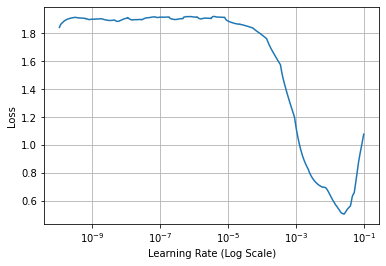

In [ ]:
# Learning Rate Finder
lrf = LearningRateFinder(model)
lrf.find((Xtrain_bc, Ytrain_bc_oh),
         startLR=1e-10, endLR=1e-1,
         stepsPerEpoch=np.ceil((len(Xtrain_bc) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()

In [ ]:
history = model.fit(x=Xtrain_bc, y=Ytrain_bc_oh, batch_size=mini_batch_size,
                    epochs=125, verbose=1,
                    callbacks=[clr], workers=5,
                    validation_data=(Xvalidation_bc, Yvalidation_bc_oh))

Epoch 1/125
94/94 [==============================] - 2s 17ms/step - loss: 1.5565 - accuracy: 0.4298 - val_loss: 0.8516 - val_accuracy: 0.5204
Epoch 2/125
94/94 [==============================] - 1s 13ms/step - loss: 0.7494 - accuracy: 0.6531 - val_loss: 0.8323 - val_accuracy: 0.5566
Epoch 3/125
94/94 [==============================] - 1s 14ms/step - loss: 0.4793 - accuracy: 0.8665 - val_loss: 0.6211 - val_accuracy: 0.8982
Epoch 4/125
94/94 [==============================] - 1s 13ms/step - loss: 0.3435 - accuracy: 0.9141 - val_loss: 0.3632 - val_accuracy: 0.9044
Epoch 5/125
94/94 [==============================] - 1s 13ms/step - loss: 0.3179 - accuracy: 0.9145 - val_loss: 0.3084 - val_accuracy: 0.9062
Epoch 6/125
94/94 [==============================] - 1s 14ms/step - loss: 0.2821 - accuracy: 0.9160 - val_loss: 0.6879 - val_accuracy: 0.9088
Epoch 7/125
94/94 [==============================] - 1s 16ms/step - loss: 0.2774 - accuracy: 0.9131 - val_loss: 0.2980 - val_accuracy: 0.8973
Epoch 

### Validate the model

In [ ]:
# Print log_loss, accuracy and F1-score
y_pred = model.predict(Xtest_bc)
y_pred_binary = np.array([np.argmax(y_pred, axis=1)]).T
f1 = f1_score(Ytest_bc, y_pred_binary, average='weighted')
print('Overall F1-Score:', f1)

Overall F1-Score: 0.8977178973719165


In [ ]:
print(classification_report(Ytest_bc, y_pred_binary))

              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90       360
         1.0       0.99      0.78      0.87       335
         2.0       1.00      1.00      1.00        59

    accuracy                           0.90       754
   macro avg       0.94      0.92      0.93       754
weighted avg       0.91      0.90      0.90       754



## Learning Curves

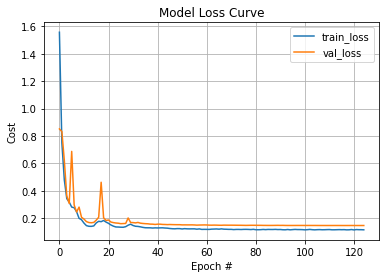

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Cost')
plt.xlabel('Epoch #')
plt.title("Model Loss Curve")
plt.legend()
plt.grid()
plt.show()

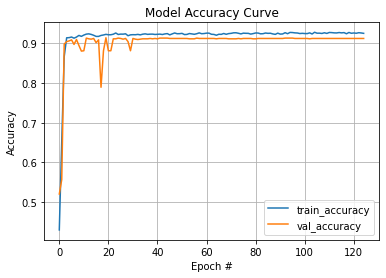

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.title("Model Accuracy Curve")
plt.legend()
plt.grid()
plt.show()

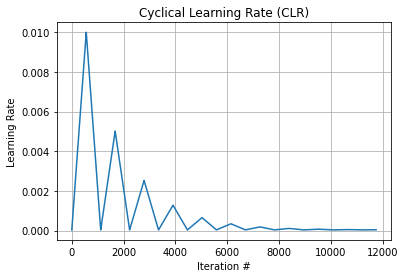

In [ ]:
plt.plot(clr.history["lr"])
plt.ylabel('Learning Rate')
plt.xlabel('Iteration #')
plt.title("Cyclical Learning Rate (CLR)")
plt.grid()
plt.show()

### Train model on entire data

In [ ]:
Xtrain_tmp = np.concatenate((Xtrain_bc, Xvalidation_bc, Xtest_bc), axis=0)
Ytrain_tmp = np.concatenate((Ytrain_bc_oh, Yvalidation_bc_oh, Ytest_bc_oh), axis=0)

In [ ]:
history = model.fit(x=Xtrain_tmp, y=Ytrain_tmp, batch_size=mini_batch_size,
                    epochs=125, verbose=1, callbacks=[clr], workers=5
                    )

Epoch 1/125
101/101 [==============================] - 1s 14ms/step - loss: 1.5129 - accuracy: 0.4383
Epoch 2/125
101/101 [==============================] - 1s 14ms/step - loss: 0.6165 - accuracy: 0.7608
Epoch 3/125
101/101 [==============================] - 1s 13ms/step - loss: 0.3464 - accuracy: 0.9145
Epoch 4/125
101/101 [==============================] - 1s 13ms/step - loss: 0.3125 - accuracy: 0.9153
Epoch 5/125
101/101 [==============================] - 2s 15ms/step - loss: 0.2795 - accuracy: 0.9143
Epoch 6/125
101/101 [==============================] - 1s 12ms/step - loss: 0.2816 - accuracy: 0.9139
Epoch 7/125
101/101 [==============================] - 1s 14ms/step - loss: 0.2550 - accuracy: 0.9171
Epoch 8/125
101/101 [==============================] - 1s 13ms/step - loss: 0.2202 - accuracy: 0.9175
Epoch 9/125
101/101 [==============================] - 1s 14ms/step - loss: 0.1951 - accuracy: 0.9162
Epoch 10/125
101/101 [==============================] - 1s 13ms/step - loss: 0.171

In [ ]:
y_pred_bc = model.predict(Xpredict)

## Create submission file

In [ ]:
y_pred_bc_binary = np.array([np.argmax(y_pred_bc, axis=1)]).T
predict_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/Dataset/test.csv")
submit_df = pd.DataFrame()
submit_df['pet_id'] = predict_df['pet_id']
submit_df['breed_category'] = y_pred_bc_binary
submit_df.head()

,pet_id,breed_category
0,ANSL_75005,1
1,ANSL_76663,0
2,ANSL_58259,0
3,ANSL_67171,0
4,ANSL_72871,0


In [ ]:
submit_df.to_csv("/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/Predictions/predictions_v57_bc_ANN.csv", index=False)